In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, SubsetRandomSampler
from torch import optim
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
from torchvision.io import read_image
import numpy as np
from collections import Counter

## Inspect dataset

In [2]:
df = pd.read_json('News_Category_Dataset_v2.json', lines = True)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [5]:
amount_of_data = len(df)
amount_of_labels = len(set(df['category']))
list_of_lengths = [len(i) for i in df['headline']]
mean_len_headline = round(np.mean(list_of_lengths), 2)
mean_words_headline = round(np.mean([i.count(" ") + 1 for i in df['headline']]), 2)
max_len_headline = max(list_of_lengths)

print(f"""\nIn this project we are interested in predicting the category of online news through their headlines.
In our dataset there are {amount_of_data} different news articles with in total {amount_of_labels} different
news categories. The length of the average headline is {mean_len_headline} characters, and {mean_words_headline} 
in terms of average number of words. The maximum headline length in terms of characters is {max_len_headline}.""")

In this project we are interested in predicting the category of online news through their headlines.
In our dataset there are 200853 different news articles with in total 41 different
news categories. The length of the average headline is 57.94 characters, and 9.54 
in terms of average number of words.


Here, we inspect the distribution of our labels in the dataset.

<BarContainer object of 41 artists>

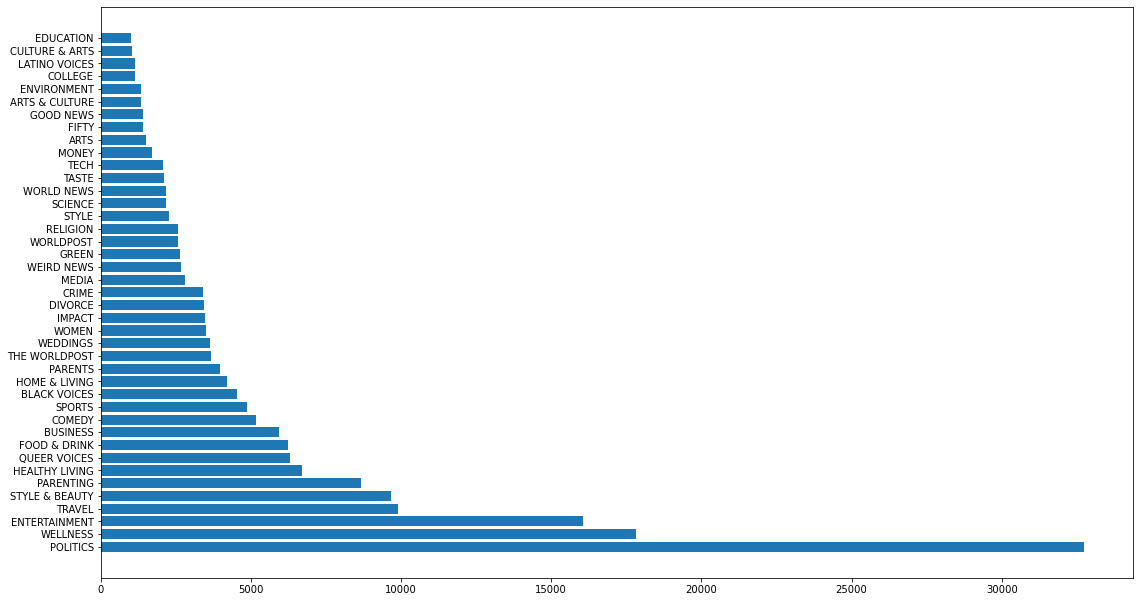

In [31]:
label_occurence = Counter(df['category']).most_common()
plt.rcParams["figure.figsize"]=(18.5, 10.5)
plt.barh([i[0] for i in label_occurence], [i[1] for i in label_occurence])

The dataset seems to be imbalanced with a lot of occurrences of news categories "Politics", "Wellness", and "Entertainment". None the less, there are at least 1.000 occurrences of each label, which means we are still content with using the full dataset.

## Create DataLoader

In [3]:
class News_Dataset(Dataset):
    def __init__(self, json_path):
        self.df = pd.read_json(json_path, lines = True)[['category', 'headline']]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        data_row = self.df.iloc[idx, :]
        data_point_category = data_row[0]
        data_point_headline = data_row[1]
        return data_point_category, data_point_headline

### Trying out the dataloader

In [7]:
dataset = News_Dataset('News_Category_Dataset_v2.json')
batch_size = 64
test_split = 0.1
val_split = 0.1
shuffle_dataset = True
random_seed = 10

# Create indices to randomly split data into training and test sets:

indices = list(range(amount_of_data))
split = int(np.floor(test_split * amount_of_data))
split_val = int(np.floor((val_split + test_split) * amount_of_data))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[split_val:], indices[split:split_val], indices[:split]

# Create samplers and DataLoaders
test_sampler = SubsetRandomSampler(test_indices)
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

test_loader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=batch_size,
                                          sampler=test_sampler)

train_loader = torch.utils.data.DataLoader(dataset, 
                                           batch_size=batch_size, 
                                           sampler=train_sampler)

val_loader = torch.utils.data.DataLoader(dataset, 
                                           batch_size=batch_size, 
                                           sampler=val_sampler)

print(len(train_indices))
print(len(test_indices))
print(len(val_indices))

# get some data points
dataiter = iter(train_loader)
categories, headlines = dataiter.next()


for i in range(1): #Run through 5 batches
    categories, headlines = dataiter.next()
    for category, headline in zip(categories, headlines): # Run through all samples in a batch
        print(category, headline)
        
print()

# get some data points
dataiter = iter(test_loader)
categories, headlines = dataiter.next()


for i in range(5): #Run through 5 batches
    categories, headlines = dataiter.next()
    for category, headline in zip(categories, headlines): # Run through all samples in a batch
        print(category, headline)
        
print()

# get some data points
dataiter = iter(val_loader)
categories, headlines = dataiter.next()


for i in range(5): #Run through 5 batches
    categories, headlines = dataiter.next()
    for category, headline in zip(categories, headlines): # Run through all samples in a batch
        print(category, headline)

160683
20085
20085
ARTS 'Wet Hot American Summer... the play?', Garage Theatre, Long Beach, CA
STYLE & BEAUTY Andy South Transgender: 'Project Runway' Contestant Now Living As A Woman
POLITICS Donald Trump Is Now Calling Obama The 'Most Valuable Player' For ISIS
ENTERTAINMENT 'Doctor Who' Does New York In This Year's Christmas Special
HEALTHY LIVING State Legislators In Colorado Join Trump In Proposing To Push People Off State Health Insurance
POLITICS Germany Schools President Donald Trump On What 'Security' Really Means
TRAVEL Ask Airfarewatchdog: I Was Bumped, Why Such Little Compensation?
GOOD NEWS These Paddle Boarders May Be Luckier Than The Powerball Winners
POLITICS The Obama Paradox
TRAVEL The World's Smallest Hotel Rooms (PHOTOS)
BLACK VOICES Jesse Williams Says Voter Fraud Is A 'Myth': 'It's Bulls**t, It's Not Real'
SPORTS WATCH: Routine Ground Ball Takes Wicked Spin
GOOD NEWS Announcing My Boldest Mission Yet
COMEDY '50 Shades Of Grey' The Musical By AVbyte (VIDEO)
COLLEGE 

CRIME Escaped Murderers Could Be Headed For Canada, Authorities Say
MONEY Safes Are Becoming A More Popular Commodity For Americans
ENTERTAINMENT Christina Milian on Domestic Abuse: "You Feel Like You're Alone"
FOOD & DRINK 5 Headaches Only Whiskey Drinkers Understand
SCIENCE The Antares Rocket Failure: So What's Wrong With 40-Year Old Russian Engines?
COMEDY Jimmy Kimmel Proves All Men Are Creeps
EDUCATION The Global Search for Education: Which Digital Device Is Best?
ENTERTAINMENT 'The Giver' Director On Controversial Trailer: 'It Was An Error'
HOME & LIVING Erica Domesek, Craft Guru, Reveals The One Mistake We're Making When We DIY
STYLE & BEAUTY Beauty Horror Stories: The Most Painful Bikini Wax Of My Life
BUSINESS Vegas ATM Steals $600 - Can You Get it Back?
PARENTS 7-Year-Old Girl With Autism Turned Away By Mall Santa Because Of Her Service Dog
ENVIRONMENT Shell's Berlin 'Science Slam' Event Reportedly Disrupted By Anti-Drilling Activists (VIDEO)
POLITICS The Military-Civilian Di